# Covid Targeted Bisulfite Sequencing PCR / PORT Models

#### Notebook Setup

In [1]:
import bisect
from collections import Counter, defaultdict
import gzip
import io
import os

import joblib
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.preprocessing import scale
from tqdm.notebook import tqdm

In [18]:
# setp working and home directories
hd = os.getcwd() + '/'
hd = f'{"/".join(hd.split("/")[0:-2])}/'
wd = '~'
hg38_gtf = f'{"/".join(hd.split("/")[0:-2])}/hg38.ncbiRefSeq.gtf.gz'

#### Set plot style

In [20]:
# use latex formatting for figures
rc('text', usetex=False)
sns.set(palette="Paired", style='white')

params = {'axes.titlesize':26,
         'axes.labelsize': 26,
         'legend.title_fontsize':26,
         'xtick.labelsize':26,
         'ytick.labelsize':26,
         'legend.markerscale':2,
         'legend.fontsize':22}
plt.rcParams.update(params)

## Declare Model Helper Functions

In [21]:
def r2(x,y):
    # return r squared
    return stats.pearsonr(x,y)[0] ** 2

In [22]:
def plot_known_predicted(known, predicted, xlabel='Known', ylabel='Predicted', label=None):
    # define optimization function
    def func(x, a, b, c):
        return a * np.asarray(x) + c
    # fit trend line
    popt, pcov = optimize.curve_fit(func, known, predicted)
    # get r squared
    rsquared = r2(predicted, func(known, *popt))
    # format plot label
    plot_label = f'$f(x)={popt[0]:.2f}x {popt[2]:.2f}, R^{{2}}={rsquared:.2f}$'
    # initialize plt plot
    fig, ax = plt.subplots(figsize=(12,12))
    # plot trend line
    ax.plot(sorted(known), func(sorted([1 + x for x in known]), *popt), 'k--', label=plot_label)
    # scatter plot
    ax.scatter(known, predicted, marker='o', alpha=0.8, color='k')
    ax.set_title(label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='both', which='major')
    ax.legend()
    return ax

In [23]:
def update_coef(all_coefs, iter_coefs, iteration_count, sample_len):
    for coef_index, coef in iter_coefs.items():
        if coef_index not in all_coefs:
            all_coefs[coef_index] = [0.0 for _ in range(sample_len)]
        all_coefs[coef_index][iteration_count] = coef

In [24]:
def unpack_loocv_coefs(loocv_coefs, site_labels):
    cleaned_coefs = {}
    for coef, coef_values in loocv_coefs.items():
        coef_label = site_labels[coef]
        coef_average = np.mean(coef_values)
        non_zero_coefs = sum([1 for x in coef_values if x])
        cleaned_coefs[coef_label] = dict(average_coef=coef_average, cv_values=coef_values, non_zero_coef_count=non_zero_coefs)
    return cleaned_coefs

In [25]:
def fit_loocv_sk_model(sample_labels: list, sample_y: np.array, sample_x: np.array, model_type, model_kwargs, verbose=True):
    model = model_type(**model_kwargs)
    predicted = {}
    model_coefs = {}
    for index in tqdm(range(len(sample_labels)), disable=True if not verbose else False):
        
        training_samples = [count for count in range(len(sample_labels)) if count != index]
        # fit model
        model.fit(sample_x[:, training_samples].T, sample_y[training_samples])
        
        # collect coef information 
        coef_list = model.coef_[0] if hasattr(model, 'predict_proba') else model.coef_
        iteration_coefs = {count: coef for count, coef in enumerate(coef_list) if coef}
        update_coef(model_coefs, iteration_coefs, index, len(sample_labels))

        test_predict = model.predict(sample_x[:, index:index+1].T)
        test_predict_proba = None
        if hasattr(model, 'predict_proba'):
            test_predict_proba = model.predict_proba(sample_x[:, index:index+1].T)[0]

        predicted[sample_labels[index]] = [sample_y[index],  test_predict[0], test_predict_proba]
    return model, predicted, model_coefs

In [26]:
def format_lg_stats(known, predicted):
    k = np.array(known)
    p = np.array(predicted)
    
    # true pos and true neg
    tp = sum(np.logical_and(k == 1,  p == 1))
    tn = sum(np.logical_and(k == 0,  p == 0))
    
    # false pos and fasle neg
    fp = sum(np.logical_and(k == 1,  p == 0))
    fn = sum(np.logical_and(k == 0,  p == 1))
    
    model_stats = {'tpr': tp / sum(k)}
    model_stats['tnr'] = tn / (len(k) - sum(k))
    model_stats['ppv'] = tp / (tp + fp)
    model_stats['npv'] = tn / (tn + fn)
    model_stats['fnr'] = fn / (fn + tp)
    model_stats['fpr'] = fp / (fp + tn)
    model_stats['fdr'] = fp / (fp + tp)
    model_stats['for'] = fn / (fn + tn)
    model_stats['acc'] = (tp + tn) / (tp + tn + fp + fn)
    model_stats['f1'] = 2*tp / (2*tp + fp + fn)
    return model_stats

In [27]:
def plot_lg(fig, known, predicted, proba, color='b', confusion_color="Blues"):
    gs = gridspec.GridSpec(nrows=100, ncols=100, figure=fig)
    ax = fig.add_subplot(gs[0:100, 0:100])

    ax_sub = fig.add_subplot(gs[60:80, 75:95])
    c_matrix = metrics.confusion_matrix(known, predicted)
    sns.heatmap(c_matrix, ax=ax_sub, annot=True, cbar=False, cmap=sns.color_palette(confusion_color, as_cmap=True))
    ax_sub.tick_params(axis='x', labelsize=12)
    ax_sub.tick_params(axis='y', labelsize=12)
    ax_sub.set_xlabel('Predicted', fontsize=14)
    ax_sub.set_ylabel('Known', fontsize=14)

    logit_roc_auc = metrics.roc_auc_score(known, predicted)
    fpr, tpr, thresholds = metrics.roc_curve(known, np.array(proba)[:,1])

    ax.plot(fpr, tpr, label=f'$area = {logit_roc_auc: 0.2f}$', lw=3.5, color=color)
    ax.plot([0, 1], [0, 1],'k--', lw=2.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    ax.legend(loc="lower right")
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    return ax 

In [28]:
def unpack_site(site, span=1):
    chrom, pos = site.split(':')
    return chrom, int(pos) - span, int(pos) + (span - 1)

In [29]:
def format_bed_site(site_label, span=1):
    chrom, start, end = unpack_site(site_label, span=span)
    return f'{chrom}\t{start}\t{end}'

In [30]:
def merge_bed(bed_sites, span=50):
    merged_sites = []
    sites = sorted(bed_sites, key=lambda x: int(x.split(':')[1]))
    sites = sorted(sites, key=lambda x: x.split(':')[0])
    
    chrom, start, end = unpack_site(sites[0], span=span)
    for site in sites[1:]:
        site_chrom, site_start, site_end = unpack_site(site, span=span)
        if site_chrom != chrom:
            merged_sites.append((chrom, start, end))
            chrom, start, end = site_chrom, site_start, site_end
        else:
            if site_start < end:
                end = site_end
            else:
                merged_sites.append((chrom, start, end))
                chrom, start, end = site_chrom, site_start, site_end
    merged_sites.append((chrom, start, end))
    return merged_sites

## Import Phenotype / Methylation Data

In [31]:
p_pheno = pd.read_csv(f'{hd}covid_p_phenotypes.csv', index_col=0)

In [33]:
phenos = pd.read_csv(f'{hd}covid_pheno_deconv.csv', index_col=0)

In [34]:
p_cats = [cat for cat in list(p_pheno) if cat not in list(phenos)]

In [35]:
p_dict = p_pheno.T.to_dict()

In [36]:
combined_phenos = {}

for sample, p_stats in phenos.T.to_dict().items():
    cleaned_stats = dict(p_stats)
    if sample in p_dict:
        cleaned_stats.update({cat:p_dict[sample][cat] for cat in p_cats})
    else:
        cleaned_stats.update({cat:np.nan for cat in p_cats})
    combined_phenos[sample] = cleaned_stats

In [37]:
all_phenos = pd.DataFrame(combined_phenos).T

In [39]:
# read in methylation data
meth_matrix = pd.read_csv(f'{hd}matrix_CGmap20_130s_cleaned.txt.gz', sep='\t', index_col=0)

In [40]:
cleaned_index = []

for sample in all_phenos.index:
    if sample not in list(meth_matrix):
        cleaned_index.append(sample.replace('S', ''))
    else:
        cleaned_index.append(sample)

In [41]:
all_phenos.index = cleaned_index

In [42]:
phenotype_matrix = all_phenos.loc[list(meth_matrix)]

In [43]:
phenotype_matrix['PCRbin'] = phenotype_matrix['PCRres'].replace({'CTRL':0, 'PCRneg':0, 'PCRpos':1})

In [44]:
meth_matrix.shape

(26061, 130)

In [45]:
# drop rows (CpG sites) with null data points
meth_matrix = meth_matrix.dropna(axis=0)

In [46]:
# drop row that have little variation (2.5)
meth_matrix = meth_matrix.loc[meth_matrix.var(axis=1) >= 0.0025]
meth_matrix.shape

(9935, 130)

In [47]:
# scale rows of matrix 
meth_matrix = pd.DataFrame(scale(meth_matrix.values, axis=1), columns=list(meth_matrix), index=meth_matrix.index)

## Figure 1 Regresion Models

In [48]:
lg_kwargs = dict(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                 class_weight=None, random_state=10, solver='liblinear', max_iter=100, 
                 multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

### A. Diagnosis LG Prediction Models

In [49]:
diag_samples, diag_values = [], []

diag_cats = dict(COVID19=1, CTRL=0, ATYPICALpn=1, BRONCHOpn=1)


for sample, diag in zip(list(phenotype_matrix.index), phenotype_matrix['Diagnosis'].values):
    if diag in diag_cats:
        diag_samples.append(sample)
        diag_values.append(diag_cats[diag])

In [50]:
len(diag_samples)

130

In [51]:
diag_meth_lg, diag_meth_classes, diag_meth_coefs = fit_loocv_sk_model(diag_samples, np.array(diag_values), 
                                                                      meth_matrix[diag_samples].values,
                                                                      LogisticRegression, lg_kwargs)

In [33]:
known_meth_diag_status, predicted_meth_diag_status, predicted_meth_diag_proba = zip(*diag_meth_classes.values())

In [34]:
diag_meth_lg_stats = format_lg_stats(known_meth_diag_status, predicted_meth_diag_status)

In [35]:
diag_meth_lg_stats

{'tpr': 0.9595959595959596,
 'tnr': 0.8709677419354839,
 'ppv': 0.9595959595959596,
 'npv': 0.8709677419354839,
 'fnr': 0.04040404040404041,
 'fpr': 0.12903225806451613,
 'fdr': 0.04040404040404041,
 'for': 0.12903225806451613,
 'acc': 0.9384615384615385,
 'f1': 0.9595959595959596}

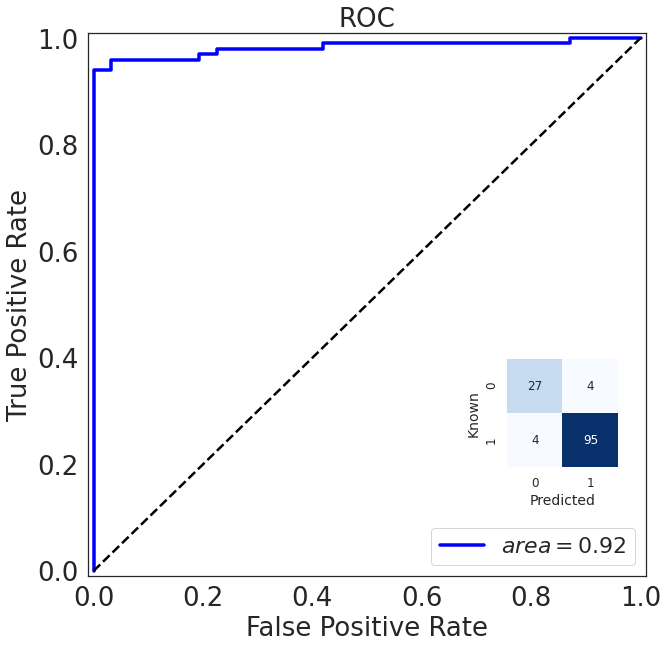

In [36]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_meth_diag_status, predicted_meth_diag_status, predicted_meth_diag_proba)
plt.savefig('fig1_a_diag_meth_pcr.svg', dpi=200)
plt.show()

In [37]:
lg_meth_diag_coefs = unpack_loocv_coefs(diag_meth_coefs, list(meth_matrix.index))

In [38]:
ninety_meth_diag_lg = int(len(diag_samples) * .9)

In [39]:
high_quality_lg_diag_coefs = {site: coef for site, coef in lg_meth_diag_coefs.items() if coef['non_zero_coef_count'] > ninety_meth_diag_lg}

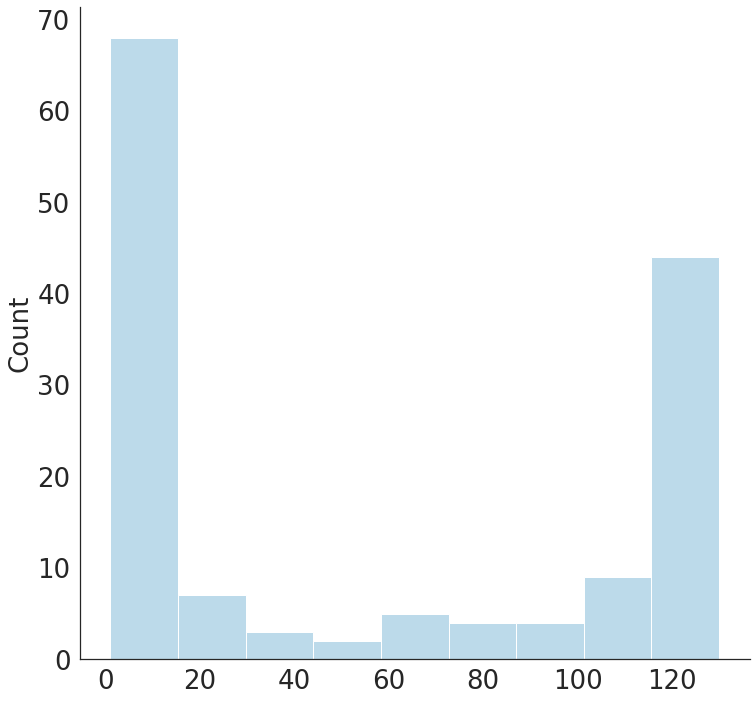

In [40]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in lg_meth_diag_coefs.values()], ax=ax)
sns.despine()
plt.savefig('lg_diag_meth_model_sites.svg', dpi=200)
plt.show()

### B. COVID Diagnosis Status - Positive vs Negative for All Respitory Illness

In [41]:
diag_resp_samples, diag_resp_values = [], []

diag_resp_cats = dict(COVID19=1, CTRL=0, ATYPICALpn=0, BRONCHOpn=0)


for sample, diag in zip(list(phenotype_matrix.index), phenotype_matrix['Diagnosis'].values):
    if diag != 'CTRL':
        diag_resp_samples.append(sample)
        diag_resp_values.append(diag_resp_cats[diag])

In [42]:
diag_resp_res = fit_loocv_sk_model(diag_resp_samples, np.array(diag_resp_values), 
                                   meth_matrix[diag_resp_samples].values,
                                   LogisticRegression, lg_kwargs)

In [43]:
diag_resp_meth_lg, diag_resp_meth_classes, diag_resp_meth_coefs = diag_resp_res 

In [44]:
known_resp_meth_diag_status, predicted_resp_meth_diag_status, predicted_resp_meth_diag_proba = zip(*diag_resp_meth_classes.values())

In [45]:
diag_resp_meth_lg_stats = format_lg_stats(known_resp_meth_diag_status, predicted_resp_meth_diag_status)

In [46]:
diag_resp_meth_lg_stats

{'tpr': 0.8,
 'tnr': 0.5172413793103449,
 'ppv': 0.8,
 'npv': 0.5172413793103449,
 'fnr': 0.2,
 'fpr': 0.4827586206896552,
 'fdr': 0.2,
 'for': 0.4827586206896552,
 'acc': 0.7171717171717171,
 'f1': 0.8}

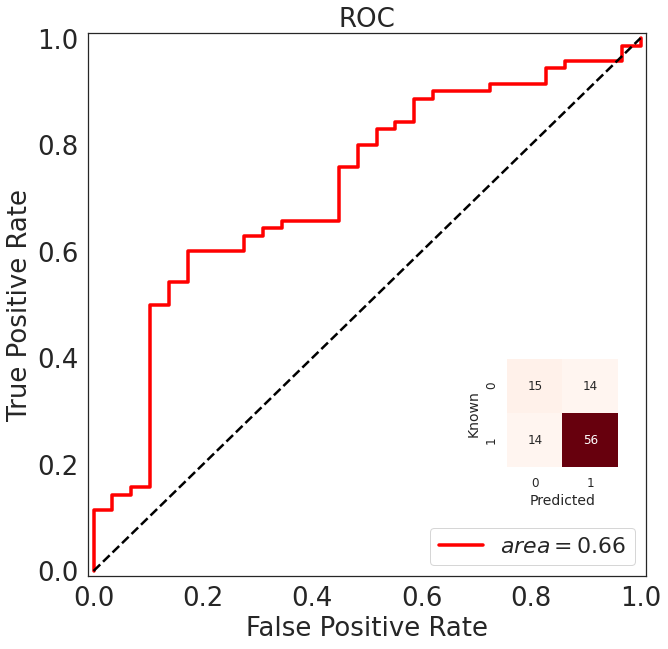

In [47]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_resp_meth_diag_status, predicted_resp_meth_diag_status, predicted_resp_meth_diag_proba, color='r', confusion_color='Reds')
plt.savefig('fig1_b_lg_resp_meth_pcr.svg', dpi=200)
plt.show()

In [48]:
lg_resp_meth_diag_coefs = unpack_loocv_coefs(diag_resp_meth_coefs, list(meth_matrix.index))

In [49]:
ninety_resp_meth_lg = int(len(diag_resp_samples) * .9)

In [50]:
high_quality_resp_lg_coefs = {site: coef for site, coef in lg_resp_meth_diag_coefs.items() if coef['non_zero_coef_count'] > ninety_resp_meth_lg}

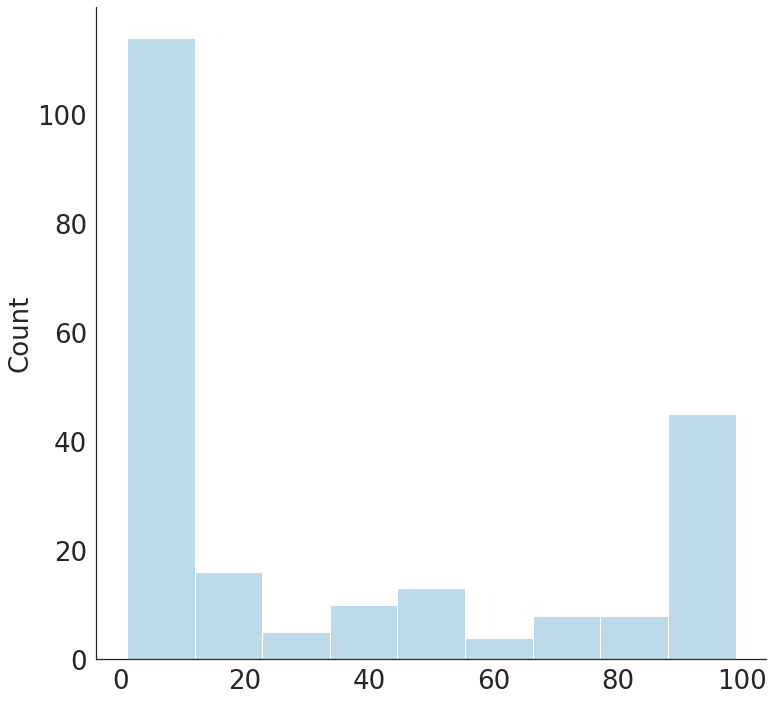

In [51]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in lg_resp_meth_diag_coefs.values()], ax=ax)
sns.despine()
plt.savefig('lg_resp_diag_meth_model_sites.svg', dpi=200)
plt.show()

### C. PCR Status - Methylation Matrix

In [52]:
pcr_samples, pcr_values = [], []

for sample, pcr_val in zip(list(phenotype_matrix.index), phenotype_matrix['PCRbin'].values):
    if not np.isnan(pcr_val):
        pcr_samples.append(sample)
        pcr_values.append(pcr_val)

In [53]:
pcr_meth_lg, pcr_meth_classes, pcr_meth_coefs = fit_loocv_sk_model(pcr_samples, np.array(pcr_values), 
                                                                   meth_matrix[pcr_samples].values,
                                                                   LogisticRegression, lg_kwargs)

In [54]:
known_meth_pcr_status, predicted_meth_pcr_status, predicted_meth_pcr_proba = zip(*pcr_meth_classes.values())

In [55]:
pcr_meth_lg_stats = format_lg_stats(known_meth_pcr_status, predicted_meth_pcr_status)

In [56]:
pcr_meth_lg_stats

{'tpr': 0.84,
 'tnr': 0.7051282051282052,
 'ppv': 0.84,
 'npv': 0.7051282051282052,
 'fnr': 0.35384615384615387,
 'fpr': 0.12698412698412698,
 'fdr': 0.16,
 'for': 0.2948717948717949,
 'acc': 0.7578125,
 'f1': 0.7304347826086957}

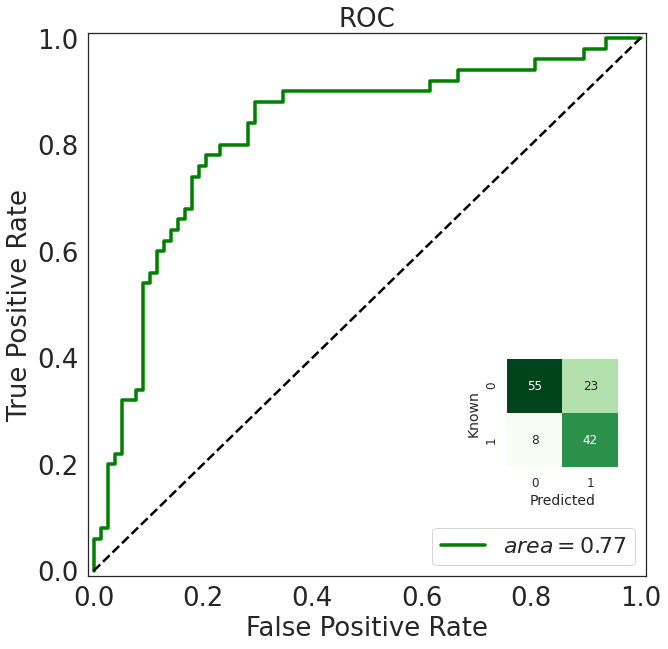

In [57]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_meth_pcr_status, predicted_meth_pcr_status, predicted_meth_pcr_proba, color='g', confusion_color='Greens')
plt.savefig('fig1_c_lg_meth_pcr.svg', dpi=200)
plt.show()

In [58]:
lg_meth_pcr_coefs = unpack_loocv_coefs(pcr_meth_coefs, list(meth_matrix.index))

In [59]:
ninety_meth_lg = int(len(pcr_samples) * .9)

In [60]:
high_quality_lg_coefs = {site: coef for site, coef in lg_meth_pcr_coefs.items() if coef['non_zero_coef_count'] > ninety_meth_lg}

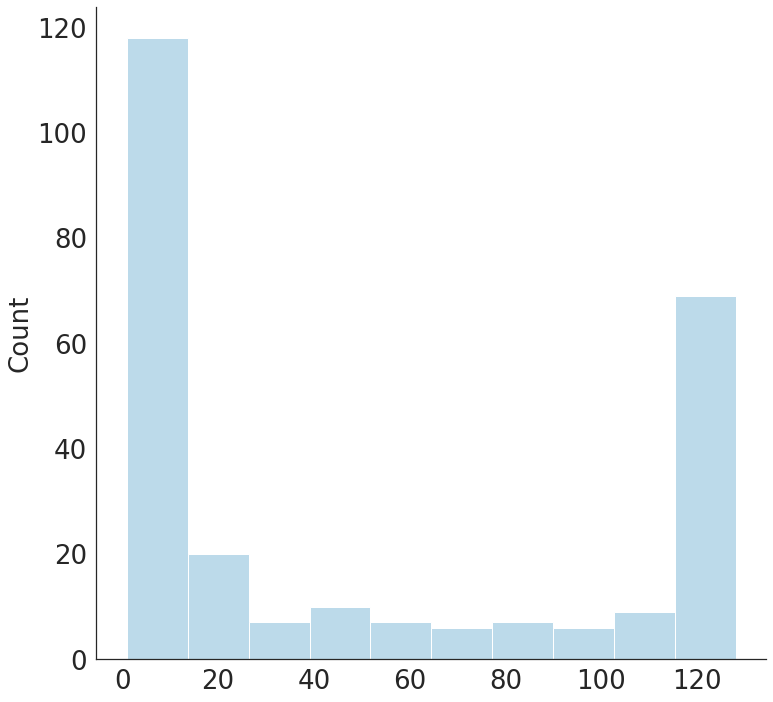

In [61]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in lg_meth_pcr_coefs.values()], ax=ax)
sns.despine()
plt.savefig('lg_meth_model_sites.svg', dpi=200)
plt.show()

### D. PORT Score Model - Methylation Matrix

In [62]:
port_samples, port_scores = [], []

for sample, port in zip(phenotype_matrix.index, phenotype_matrix['Port Score (Pneumonia Severity Index)']):
    if not np.isnan(port):
        port_samples.append(sample)
        port_scores.append(port)

In [63]:
en_kwargs = dict(alpha=1.0, l1_ratio=.8, fit_intercept=True, normalize=False, 
                 precompute=False, max_iter=2000, copy_X=True, tol=0.00001, 
                 warm_start=False, positive=False, random_state=None, 
                 selection='random')

In [64]:
port_lm, port_predictions, port_coefs = fit_loocv_sk_model(port_samples, np.array(port_scores), meth_matrix[port_samples].values,
                                                           ElasticNet, en_kwargs)

/u/home/c/colinpat/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


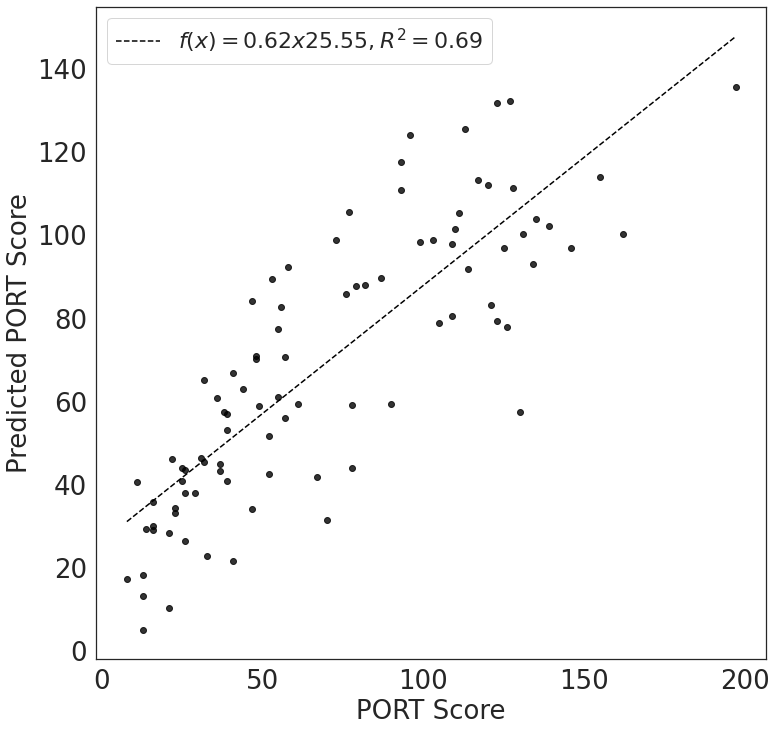

In [65]:
known, predicted, _ = zip(*port_predictions.values())

ax = plot_known_predicted(known, predicted, xlabel='PORT Score', ylabel='Predicted PORT Score')
plt.savefig('fig1_d_port_lm.svg', dpi=200)

In [66]:
cleaned_port_coefs = unpack_loocv_coefs(port_coefs, list(meth_matrix.index))

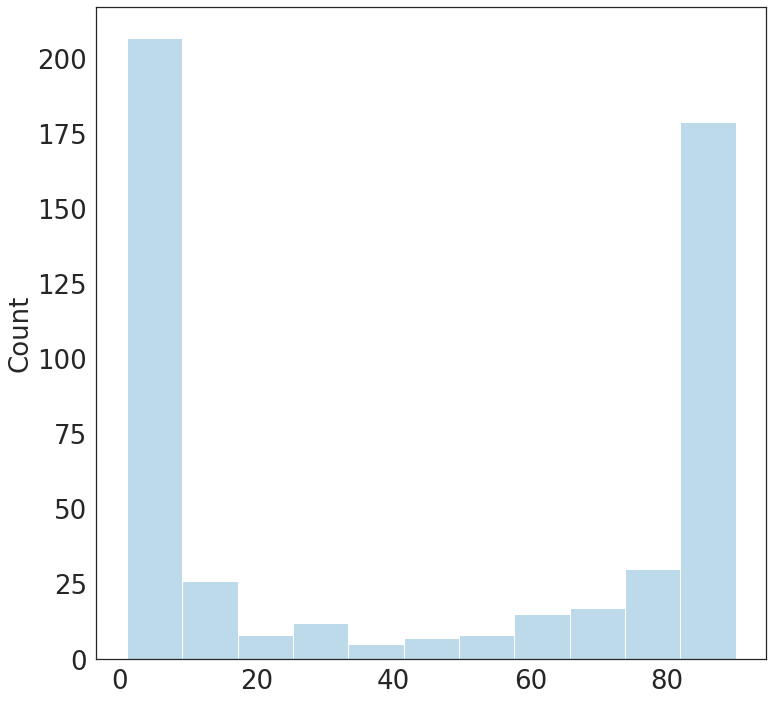

In [67]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in cleaned_port_coefs.values()], ax=ax)
plt.savefig('port_lm_model_sites.svg', dpi=200)
plt.show()

In [68]:
port_sites = [(site, coef["average_coef"], coef["non_zero_coef_count"]) for site, coef in cleaned_port_coefs.items()]

In [69]:
port_sites.sort(key=lambda x: abs(x[1]), reverse=True)
port_sites.sort(key=lambda x: abs(x[2]), reverse=True)

In [70]:
ninety_port = int(len(port_scores) * .9)

In [71]:
high_quality_port_coefs = {site: coef for site, coef in cleaned_port_coefs.items() if coef['non_zero_coef_count'] > ninety_port}

In [72]:
len(high_quality_port_coefs)

179

## Supplementary Regression Models

### PCR Status - Methylation Based Cell Type Estimates

In [93]:
deconv_cats = ['bsBcell',
               'bsCD4',
               'bsCD8',
               'bsMono',
               'bsNK',
               'bsNeut']

In [94]:
cell_comp_matrix = phenotype_matrix[deconv_cats].T

In [95]:
lg_meth_deconv = fit_loocv_sk_model(pcr_samples, np.array(pcr_values), 
                                    cell_comp_matrix[pcr_samples].values,
                                    LogisticRegression, lg_kwargs)

In [96]:
pcr_meth_deconv_lg, pcr_meth_deconv_classes, pcr_meth_deconv_coefs = lg_meth_deconv

In [97]:
lg_pcr_cell_comp_coefs = unpack_loocv_coefs(pcr_meth_deconv_coefs, deconv_cats)

In [98]:
{cell:cell_info['average_coef'] for cell, cell_info in lg_pcr_cell_comp_coefs.items()}

{'bsCD8': 0.21574535960099145, 'bsNeut': -3.3000803319912864}

In [99]:
known_meth_deconv_pcr, predicted_meth_deconv_pcr, predicted_meth_deconv_pcr_proba = zip(*pcr_meth_deconv_classes.values())

In [100]:
pcr_meth_deconv_lg_stats = format_lg_stats(known_meth_deconv_pcr, predicted_meth_deconv_pcr)

In [101]:
pcr_meth_deconv_lg_stats

{'tpr': 0.4,
 'tnr': 0.8974358974358975,
 'ppv': 0.4,
 'npv': 0.8974358974358975,
 'fnr': 0.2857142857142857,
 'fpr': 0.3,
 'fdr': 0.6,
 'for': 0.10256410256410256,
 'acc': 0.703125,
 'f1': 0.5128205128205128}

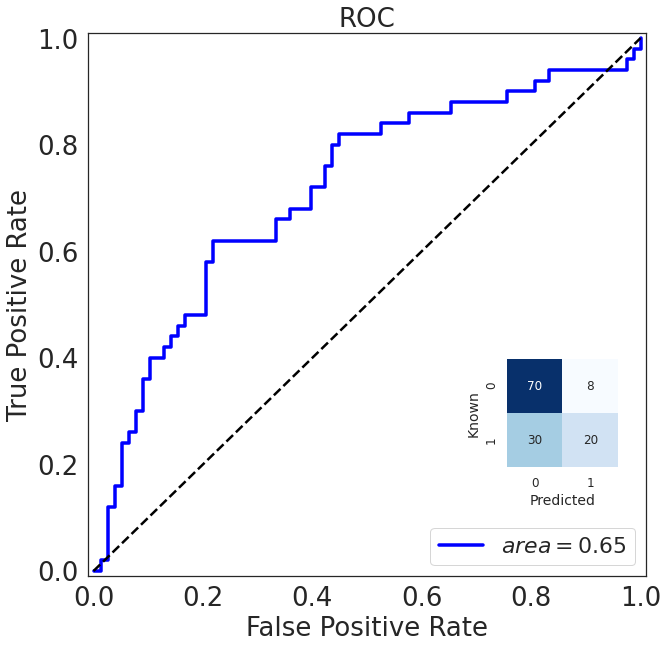

In [102]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_meth_deconv_pcr, predicted_meth_deconv_pcr, predicted_meth_deconv_pcr_proba)
plt.savefig('lg_cell_deconv_pcr.svg', dpi=200)
plt.show()

### PCR Status - Respitory Illness Only

In [103]:
pcr_resp_samples, pcr_resp_values = [], []

for sample, pcr_val, diag in zip(list(phenotype_matrix.index), phenotype_matrix['PCRbin'].values, phenotype_matrix['Diagnosis'].values):
    if not np.isnan(pcr_val) and diag != 'CTRL':
        pcr_resp_samples.append(sample)
        pcr_resp_values.append(pcr_val)

In [104]:
lg_resp_meth_deconv = fit_loocv_sk_model(pcr_resp_samples, np.array(pcr_resp_values), 
                                    meth_matrix[pcr_resp_samples].values,
                                    LogisticRegression, lg_kwargs)

In [105]:
pcr_resp_meth_deconv_lg, pcr_resp_meth_deconv_classes, pcr_resp_meth_deconv_coefs = lg_resp_meth_deconv

In [106]:
lg_resp_pcr_cell_comp_coefs = unpack_loocv_coefs(pcr_resp_meth_deconv_coefs, list(meth_matrix.index))

In [107]:
known_resp_meth_deconv_pcr, predicted_resp_meth_deconv_pcr, predicted_resp_meth_deconv_pcr_proba = zip(*pcr_resp_meth_deconv_classes.values())

In [108]:
pcr_resp_meth_deconv_lg_stats = format_lg_stats(known_resp_meth_deconv_pcr, predicted_resp_meth_deconv_pcr)

In [109]:
pcr_resp_meth_deconv_lg_stats

{'tpr': 0.72,
 'tnr': 0.5957446808510638,
 'ppv': 0.72,
 'npv': 0.5957446808510638,
 'fnr': 0.34545454545454546,
 'fpr': 0.3333333333333333,
 'fdr': 0.28,
 'for': 0.40425531914893614,
 'acc': 0.6597938144329897,
 'f1': 0.6857142857142857}

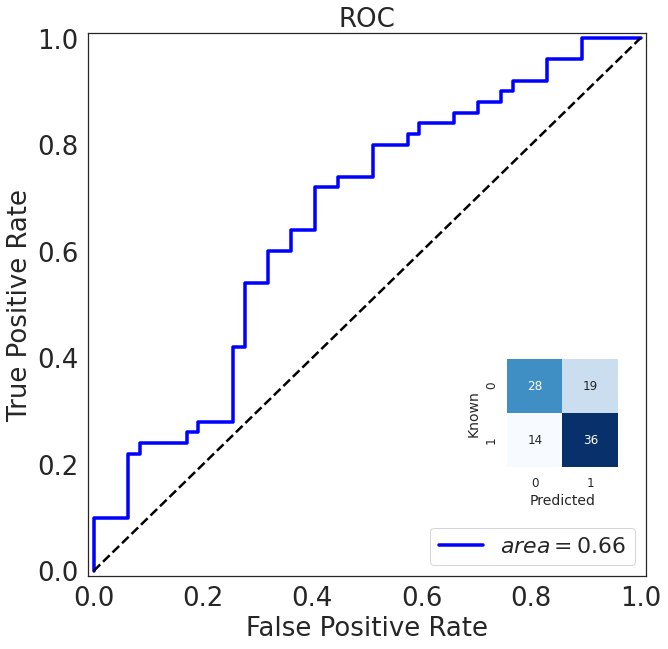

In [110]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_resp_meth_deconv_pcr, predicted_resp_meth_deconv_pcr, predicted_resp_meth_deconv_pcr_proba)
plt.savefig('lg_resp_cell_deconv_pcr.svg', dpi=200)
plt.show()

### PCR Status - Cell Sorting

In [111]:
cell_sorted_cats =  ['Neut',
'Lympho',
'WBC',
'Mono']

In [112]:
cell_sort_comp_matrix = phenotype_matrix[cell_sorted_cats].T
cell_sort_comp_matrix = cell_sort_comp_matrix.dropna(axis=1)

In [113]:
sort_samples, sort_values = [], []

for sample, value in zip(pcr_samples, pcr_values):
    if sample in list(cell_sort_comp_matrix):
        sort_samples.append(sample)
        sort_values.append(value)

In [114]:
cell_sort_comp_matrix = cell_sort_comp_matrix[sort_samples]

In [115]:
lg_cell_sort = fit_loocv_sk_model(sort_samples, np.array(sort_values), 
                                  cell_sort_comp_matrix.values,
                                  LogisticRegression, lg_kwargs)

In [116]:
pcr_sort_lg, pcr_sort_classes, pcr_sort_coefs = lg_cell_sort

In [117]:
lg_sort_coefs = unpack_loocv_coefs(pcr_sort_coefs, cell_sorted_cats)

In [118]:
{cell:cell_info['average_coef'] for cell, cell_info in lg_sort_coefs.items()}

{'Neut': -0.08280173254376619,
 'Lympho': 0.43481394189165,
 'Mono': -0.0036214833916122634,
 'WBC': -0.0005057516932690782}

In [119]:
known_sort_pcr, predicted_sort_pcr, predicted_sort_pcr_proba = zip(*pcr_sort_classes.values())

In [120]:
pcr_sort_lg_stats = format_lg_stats(known_sort_pcr, predicted_sort_pcr)

In [121]:
pcr_sort_lg_stats

{'tpr': 0.38,
 'tnr': 0.8181818181818182,
 'ppv': 0.38,
 'npv': 0.8181818181818182,
 'fnr': 0.42424242424242425,
 'fpr': 0.32978723404255317,
 'fdr': 0.62,
 'for': 0.18181818181818182,
 'acc': 0.6456692913385826,
 'f1': 0.4578313253012048}

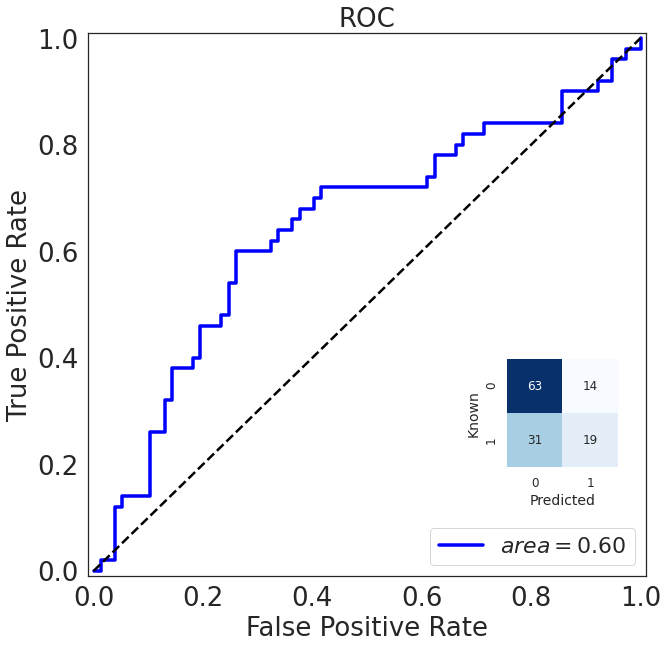

In [122]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_sort_pcr, predicted_sort_pcr, predicted_sort_pcr_proba)
plt.savefig('lg_cell_sort_pcr.svg', dpi=200)
plt.show()

### CT LG Model

In [123]:
ct_samples, ct_values = [], []


ct_cats = {'CTRL':0, 'atypical':1, 'bacterial':1, 'normal':0, 'viral':1}

for sample, ct_status in zip(list(phenotype_matrix.index), phenotype_matrix['CT'].values):
    if ct_status in ct_cats:
        ct_samples.append(sample)
        ct_values.append(ct_cats[ct_status])

In [124]:
ct_meth_lg, ct_meth_classes, ct_meth_coefs = fit_loocv_sk_model(ct_samples, np.array(ct_values), 
                                                                meth_matrix[ct_samples].values,
                                                                LogisticRegression, lg_kwargs)

In [125]:
known_meth_ct_status, predicted_meth_ct_status, predicted_meth_ct_proba = zip(*ct_meth_classes.values())

In [126]:
ct_meth_lg_stats = format_lg_stats(known_meth_ct_status, predicted_meth_ct_status)

In [127]:
ct_meth_lg_stats

{'tpr': 0.6617647058823529,
 'tnr': 0.7741935483870968,
 'ppv': 0.6617647058823529,
 'npv': 0.7741935483870968,
 'fnr': 0.23728813559322035,
 'fpr': 0.323943661971831,
 'fdr': 0.3382352941176471,
 'for': 0.22580645161290322,
 'acc': 0.7153846153846154,
 'f1': 0.7086614173228346}

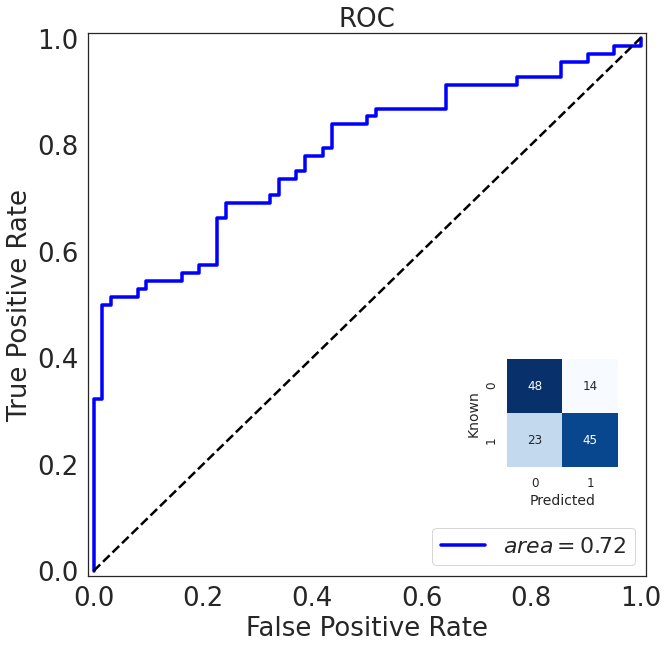

In [128]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_meth_ct_status, predicted_meth_ct_status, predicted_meth_ct_proba)
plt.savefig('ct_meth_pcr.svg', dpi=200)
plt.show()

In [129]:
lg_meth_ct_coefs = unpack_loocv_coefs(ct_meth_coefs, list(meth_matrix.index))

In [130]:
ninety_meth_ct_lg = int(len(pcr_samples) * .9)

In [131]:
high_quality_lg_ct_coefs = {site: coef for site, coef in lg_meth_ct_coefs.items() if coef['non_zero_coef_count'] > ninety_meth_ct_lg}

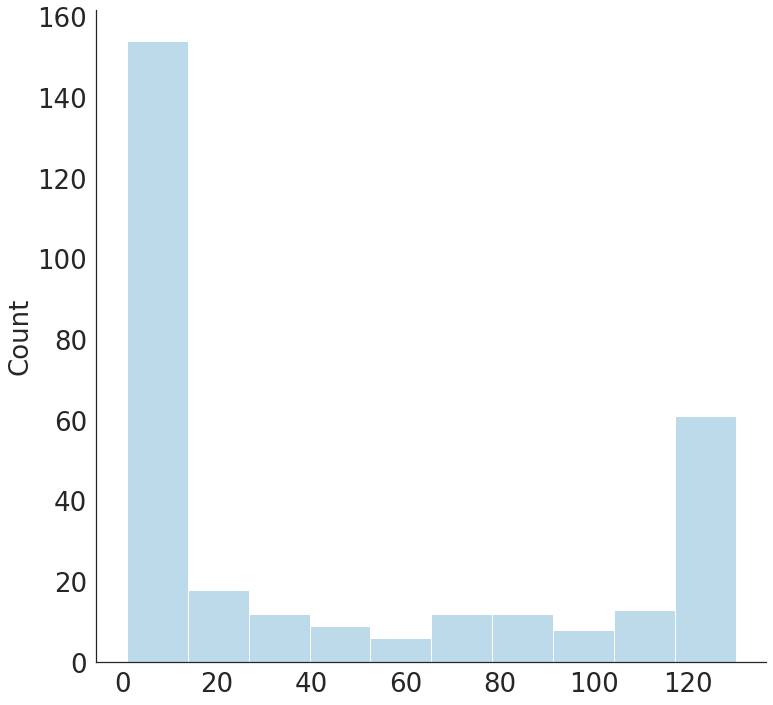

In [132]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in lg_meth_ct_coefs.values()], ax=ax)
sns.despine()
plt.savefig('lg_ct_meth_model_sites.svg', dpi=200)
plt.show()

### Diagnosis LG Cell Deconv

In [133]:
cell_deconv_kwargs = {'penalty': 'elasticnet',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'saga',
 'max_iter': 100,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': 0.5}

In [134]:
diag_deconv_lg, diag_deconv_classes, diag_deconv_coefs = fit_loocv_sk_model(diag_samples, np.array(diag_values), 
                                                                            phenotype_matrix[deconv_cats].loc[diag_samples].T.values,
                                                                            LogisticRegression, cell_deconv_kwargs)

In [135]:
known_deconv_diag_status, predicted_deconv_diag_status, predicted_deconv_diag_proba = zip(*diag_deconv_classes.values())

In [136]:
diag_deconv_lg_stats = format_lg_stats(known_deconv_diag_status, predicted_deconv_diag_status)

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [137]:
diag_deconv_lg_stats

{'tpr': 1.0,
 'tnr': 0.0,
 'ppv': 1.0,
 'npv': 0.0,
 'fnr': 0.23846153846153847,
 'fpr': nan,
 'fdr': 0.0,
 'for': 1.0,
 'acc': 0.7615384615384615,
 'f1': 0.8646288209606987}

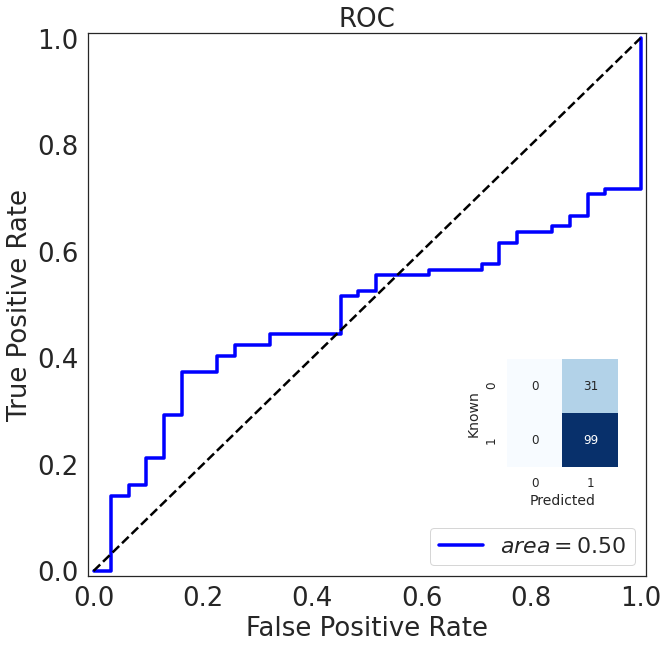

In [138]:
fig = plt.figure(figsize=(10,10))
ax = plot_lg(fig, known_deconv_diag_status, predicted_deconv_diag_status, predicted_deconv_diag_proba)
plt.savefig('diag_deconv_pcr.svg', dpi=200)
plt.show()

In [139]:
lg_deconv_diag_coefs = unpack_loocv_coefs(diag_deconv_coefs, deconv_cats)

In [140]:
{cell: cell_info['average_coef'] for cell, cell_info in lg_deconv_diag_coefs.items()}

{'bsCD8': 0.5118082798875645, 'bsNeut': -0.4873223947285479}

### Epigenetic Clock - Methylation Matrix

In [141]:
age_samples, ages = [], []
for sample, age in phenotype_matrix['AGE'].to_dict().items():
    if age:
        ages.append(age)
        age_samples.append(sample)

In [142]:
age_en_kwargs = dict(alpha=1.0, l1_ratio=.9, fit_intercept=True, normalize=False, 
                     precompute=False, max_iter=2000, copy_X=True, tol=0.00001, 
                     warm_start=False, positive=False, random_state=None, 
                     selection='random')

In [143]:
age_lm, age_predictions, age_coefs = fit_loocv_sk_model(age_samples, np.array(ages), 
                                                        meth_matrix[age_samples].values,
                                                        ElasticNet, age_en_kwargs)

/u/home/c/colinpat/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


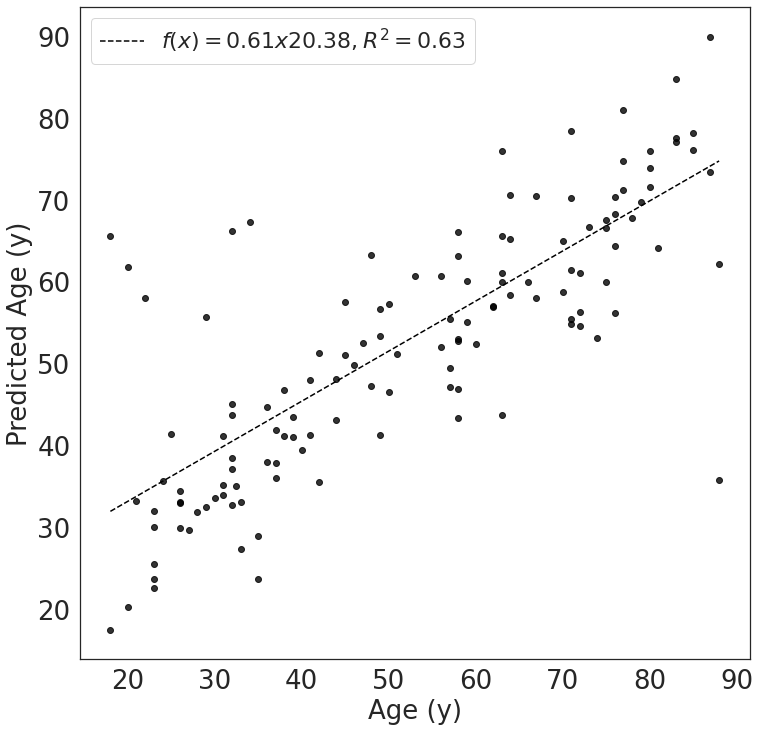

In [144]:
known, predicted, _ = zip(*age_predictions.values())

ax = plot_known_predicted(known, predicted, xlabel='Age (y)', ylabel='Predicted Age (y)')
plt.savefig('age_lm.svg', dpi=200)

In [145]:
cleaned_age_coefs = unpack_loocv_coefs(age_coefs, list(meth_matrix.index))

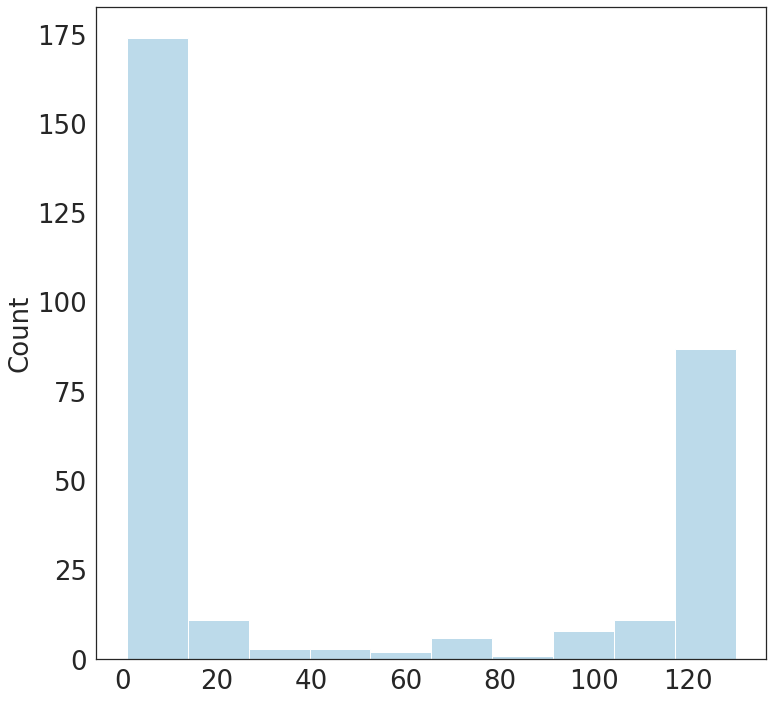

In [146]:
fit, ax = plt.subplots(figsize=(12,12))

sns.histplot([value['non_zero_coef_count'] for value in cleaned_age_coefs.values()], ax=ax)
plt.savefig('age_lm_model_sites.svg', dpi=200)
plt.show()

In [147]:
age_sites = [(site, coef["average_coef"], coef["non_zero_coef_count"]) for site, coef in cleaned_age_coefs.items()]

In [148]:
age_sites.sort(key=lambda x: abs(x[1]), reverse=True)
age_sites.sort(key=lambda x: abs(x[2]), reverse=True)

In [149]:
ninety_age = int(len(ages) * .9)

In [150]:
high_quality_age_coefs = {site: coef for site, coef in cleaned_age_coefs.items() if coef['non_zero_coef_count'] > ninety_age}

## Combine and Export Model Results

In [151]:
def get_ordered_predictions(sample_list, sample_results):
    predicted, known = [], []
    for sample in sample_list:
        value = sample_results.get(sample, None)
        sample_p, sample_k = np.nan, np.nan
        if value:
            sample_k = value[0]
            sample_p = value[1]
        predicted.append(sample_p)
        known.append(sample_k)
    return predicted, known

In [152]:
meth_diag_p, meth_diag_k = get_ordered_predictions(list(phenotype_matrix.index), diag_meth_classes)
diag_covid_vs_resp_p, diag_covid_vs_resp_k  = get_ordered_predictions(list(phenotype_matrix.index), diag_resp_meth_classes)
meth_pcr_predicted, meth_pcr_known = get_ordered_predictions(list(phenotype_matrix.index), pcr_meth_classes)
port_predicted, port_known = get_ordered_predictions(list(phenotype_matrix.index), port_predictions)
age_predicted, age_known = get_ordered_predictions(list(phenotype_matrix.index), age_predictions)

In [153]:
predictions = [meth_diag_p, meth_diag_k,
               diag_covid_vs_resp_p, diag_covid_vs_resp_k,
               meth_pcr_predicted, meth_pcr_known,
               port_predicted, port_known,
               age_predicted, age_known]
pred_labels = ['Meth Respitory Illness Diag Predicted', 'Meth Respitory Illness Diag Known',
               'Meth COVID vs Other Respitory Illness Diag Predicted', 'Meth COVID vs Other Respitory Illness Diag Known',
               'Meth COVID PCR Status Predicted', 'Meth COVID PCR Status Predicted',
               'Port Predicted', 'Port Known',
               'Age Predicted', 'Age Known'] 

In [154]:
prediction_df = pd.DataFrame(columns=list(phenotype_matrix.index), data=predictions, index=pred_labels).T

In [155]:
prediction_df.to_csv('Covid_diag_predictions.tsv', sep='\t')

## Annotated High Quality Regression Sites

### Declare Annotation Helper Functions

In [156]:
def binary_search(site, feature_spans):
    search_features = [x[0] for x in feature_spans[site[0]]]
    bisect_index = bisect.bisect(search_features, site[1])
    upstream_gene = feature_spans[site[0]][bisect_index - 1]
    upstream_dist = upstream_gene[0] - site[1]
    downstream_gene = feature_spans[site[0]][bisect_index]
    downstream_dist = downstream_gene[0] - site[1]
    bookmark = upstream_gene if abs(upstream_dist) < downstream_dist else downstream_gene
    return dict(upstream_gene_id=upstream_gene[1], upstream_gene_start=upstream_gene[0], feature_upstream_dist=upstream_dist,
                downstream_gene_id=downstream_gene[1], downstream_gene_start=downstream_gene[0], feature_downstream_dist=downstream_dist,
                bookmark_gene=bookmark[1])

In [157]:
def get_book_mark_info(site, bookmark_gene):
    if bookmark_gene[0]['start'] <= site[1] <= bookmark_gene[0]['end']:
        feature_hits = []
        for exon in bookmark_gene[1:]:
            if exon['start'] <= site[1] <= exon['end']:
                if exon['feature'] != 'transcript':
                    feature_hits.append(exon['feature'])
        if feature_hits:
            if 'exon' in feature_hits:
                return 'exon'
            else:
                return feature_hits[0]
        return 'intragenic'
    else:
        return 'intergenic'

In [158]:
def update_coefs_meta(coefs, gene_reference, feature_spans):
    for site in coefs:
        chrom, pos = site.split(':')
        bookmark_info = binary_search((chrom, int(pos)), feature_spans)
        bookmark_info['hit_type'] = get_book_mark_info((chrom, int(pos)), gene_reference[bookmark_info['bookmark_gene']])
        bookmark_info['chrom'] = chrom
        bookmark_info['pos'] = pos
        coefs[site].update(bookmark_info)

In [159]:
def format_coefs_annotations(coefs, output_path=None):
    coef_df = pd.DataFrame(coefs).T
    coef_df = coef_df.drop('cv_values', axis=1)
    if output_path:
        coef_df.to_csv(output_path, sep='\t')
    return coef_df

### Site Annotation and Export

In [160]:
# import reference annotations

hg38_refgene_annotations = {}

with io.BufferedReader(gzip.open(hg38_gtf, 'rb')) as ref:
    for b_line in tqdm(ref):
        line = b_line.decode()
        line_info = line.strip().split('\t')
        chrom, _, feature_type, start, end, score, strand, frame = line_info[0:-1]
        transcript_info = {}
        for info in line_info[-1].split(';'):
            seg = info.strip().split(' ')
            if len(seg)== 2:
                transcript_info[seg[0]] = seg[1].replace('"', '')
        info = dict(chrom=chrom, feature=feature_type, start=int(start), end=int(end), strand=strand, frame=frame, attributes=transcript_info)
        if transcript_info['gene_name'] not in hg38_refgene_annotations:
            hg38_refgene_annotations[transcript_info['gene_name']] = [info]
        else:
            hg38_refgene_annotations[transcript_info['gene_name']].append(info)

In [161]:
feature_spans = defaultdict(list)

count = 0

for feature, feature_info in tqdm(hg38_refgene_annotations.items()):
    transcript_info = feature_info[0]
    if transcript_info['feature'] != 'transcript':
        continue
    tss_start = transcript_info['start'] if transcript_info['strand'] == '+' else transcript_info['end']
    feature_spans[transcript_info['chrom']].append((tss_start, transcript_info['attributes']['gene_name']))

In [162]:
for feature_list in feature_spans.values():
    feature_list.sort(key=lambda x: x[0])

In [163]:
annotation_coefs = {'resp_diag':high_quality_lg_diag_coefs, 
                    'covid_vs_resp_diag':high_quality_resp_lg_coefs, 
                    'covid_pcr_status':high_quality_lg_coefs, 
                    'port':high_quality_port_coefs, 
                    'age':high_quality_age_coefs}

In [164]:
[len(x) for x in annotation_coefs.values()]

[42, 45, 69, 179, 87]

In [165]:
for coefs in annotation_coefs.values():
    update_coefs_meta(coefs, hg38_refgene_annotations, feature_spans)

In [166]:
coef_dfs = {}

for model, coefs in annotation_coefs.items():
    coef_dfs[model] =  format_coefs_annotations(coefs, output_path=f'{model}_sites.tsv')

### Model Site Overlap

In [167]:
def get_site_overlap(coefs_1, coefs_2):
    overlapping_sites = set(coefs_1).intersection(coefs_2)
    return len(overlapping_sites) / len(coefs_1), overlapping_sites

In [168]:
overlapping_sites = {}
overlap_prop = []

for model, coefs in annotation_coefs.items():
    model_overlap = []
    for comp_model, comp_coefs in annotation_coefs.items():
        overlap, sites = get_site_overlap(coefs, comp_coefs)
        model_overlap.append(overlap)
        if model != comp_model:
            models = sorted([model, comp_model])
            overlapping_sites[f'{models[0]} vs {models[1]}'] = sites
    overlap_prop.append(model_overlap)

In [169]:
overlap_df = pd.DataFrame(overlap_prop, columns=[f'Denominator {x}' for x in list(annotation_coefs.keys())],
                          index=[f'Comp Model {x}' for x in list(annotation_coefs.keys())]).T

In [170]:
overlap_df

,Comp Model resp_diag,Comp Model covid_vs_resp_diag,Comp Model covid_pcr_status,Comp Model port,Comp Model age
Denominator resp_diag,1.00000,0.000000,0.014493,0.005587,0.011494
Denominator covid_vs_resp_diag,0.00000,1.000000,0.144928,0.005587,0.011494
Denominator covid_pcr_status,0.02381,0.222222,1.000000,0.016760,0.011494
Denominator port,0.02381,0.022222,0.043478,1.000000,0.126437
Denominator age,0.02381,0.022222,0.014493,0.061453,1.000000


In [171]:
with open('intersecting_model_sites.tsv', 'w') as out:
    for cat, sites in overlapping_sites.items():
        cats = cat.split(' vs ')
        for site in sites:
            out.write(f'{cats[0]}\t{cats[1]}\t{site}\n')